# DE analysis and EDA

In this thread, we discuss DE analysis and EDA to identify potential issues. 

## Summary:
Overall, new approach can do the followings differently and see how the results improve:
- Not filling the missing values and reporting DE values for only those genes with measured counts
- Using a different type of pseudobulking, e.g. taking mean instead of summing.
- Using a different model for DE fitting, e.g. non linear.
- Taking into account the number of cells for each pseudobulked sample. We can see certain samples have only one cell.

## Plan
Jalil ->work on different DE analysis. Choice of normalizing, limma or not limma, etc. If someone has experience with DE analysis, would be appreciated to help me.
 
@lnalinaf @antoninadolgorukova -> can you start with EDA and define some kind of protocol to identify potential issues? the orignal  de-train can be a default input while i produce new results. we can continue on how to define this protocol in the comments. 

## Notebooks and data

Notebook to load kaggle_data and pseudobulk it:
https://www.kaggle.com/code/jalilnourisa/op2-post-pseudobulking?scriptVersionId=163713576 

Notebook that analyzes the issues with the original de-train data  
https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/discussion/466181


## Experiment setup
https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/data
- 6 plates, 2 plates for each of 3 donors 
- 144 compounds + 3 controls
- per plate: 96 wells, 72 compounds (one well each) + 3 (8 well each) control 
- all different cell types are assumed to be in each well 

**Potential confounders**: donor, row (wells of each row are put together for sequencing), and plate.

## Pseudobulking 
**Method used by the hosts for DE analysis:**: 
Single cell measurements are aggregated for cell types of each well (of each plate). 
**Potential alternative approach:**: 
We can take mean of counts instead of summing. 

## Method choice
**Method used by the hosts for DE analysis:**: 
- they used Voom function that normalizes the pseudobulked data and also fills the missing values for genes with 0 counts. It should be noted that we have around 40% missingness after pseudobulking. **Issues**: we get DE values for 0 count genes.
- Model design: for each cell type and gene:
$$
x_0 + x_1c_i + x_2l_i + x_3d_i + x_4p_i
$$
i is for observations, where:
- $c_i$ compound, binary (0, 1) for control and given treatment (double check?) (or 146 categorical) 
- $l_i$ library, categorical 48 conditions
- $d_i$ donor, categorical 3 conditions
- $p_i$ plate, categorical 6 conditions 
  
  **Issues**

- library_id already includes plate and donor -> maybe using row (8 conditions) can help in stability of the solution 

**Potential alternative approach:**: 
- no filling the missing genes. 
- using a different fitting model


Antonina Dolgorukova
Alina F

# Imports 

In [8]:
import pandas as pd
import numpy as np
import sklearn
import scipy

import anndata as ad
import scanpy as sc
import os

import os, binascii
data_dir = '../../input/kaggle/input/open-problems-single-cell-perturbations'
os.path.isdir(data_dir)

True

# Format adata

Here we load expression data (long format) and converting it into an AnnData object (wide sparse format).

You'll need to increase your instance RAM to at least 64 GB.

In [21]:
adata_train_df = pd.read_parquet(os.path.join(data_dir, 'adata_train.parquet'))
adata_obs_meta_df = pd.read_csv(os.path.join(data_dir, 'adata_obs_meta.csv'))
de_train = pd.read_parquet(os.path.join(data_dir, 'de_train.parquet'))
adata_excluded_ids_df = pd.read_csv(os.path.join(data_dir, 'adata_excluded_ids.csv'))

In [ ]:
reindexed_adata_train_df = adata_train_df.reset_index().set_index(['obs_id', 'gene'])
adata_excluded_ids_index = adata_excluded_ids_df.set_index(['obs_id', 'gene']).sort_index().index

selection = ~reindexed_adata_train_df.index.isin(adata_excluded_ids_index)
adata_train_df = reindexed_adata_train_df[selection]

adata_train_df = adata_train_df.reset_index().set_index('index')

In [ ]:
adata_train_df['obs_id'] = adata_train_df['obs_id'].astype('category')
adata_train_df['gene'] = adata_train_df['gene'].astype('category')

obs_ids = adata_train_df['obs_id'].unique()
obs_id_map = dict(zip(obs_ids, range(len(obs_ids))))

genes = adata_train_df['gene'].unique()
gene_map = dict(zip(genes, range(len(genes))))

adata_train_df['obs_index'] = adata_train_df['obs_id'].map(obs_id_map)
adata_train_df['gene_index'] = adata_train_df['gene'].map(gene_map)

normalized_counts_values = adata_train_df['normalized_count'].to_numpy()
counts_values = adata_train_df['count'].to_numpy()

row_indices = adata_train_df['obs_index'].to_numpy()
col_indices = adata_train_df['gene_index'].to_numpy()

counts = scipy.sparse.csr_matrix((counts_values, (row_indices, col_indices)))

obs_df = pd.Series(obs_ids, name='obs_id').to_frame()
var_df = pd.Series(genes, name='gene').to_frame()

obs_df = obs_df.set_index('obs_id')
var_df = var_df.set_index('gene')

obs_df.index = obs_df.index.astype('str')
var_df.index = var_df.index.astype('str')

kaggle_adata = ad.AnnData(
    X=counts,
    obs=obs_df,
    var=var_df,
    dtype=np.uint32,
)

index_ordering_before_join = kaggle_adata.obs.index
kaggle_adata.obs = kaggle_adata.obs.join(adata_obs_meta_df.set_index('obs_id'))
index_ordering_after_join = kaggle_adata.obs.index
assert (index_ordering_before_join == index_ordering_after_join).all()

kaggle_adata.write_h5ad('../../output/de_analysis/kaggle_adata.h5ad')

# Pseudobulking counts by cell type

In [5]:
import anndata
import pandas as pd
import numpy as np
import sklearn
import scipy

import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt

import os, binascii
kaggle_adata = anndata.read_h5ad('../../output/de_analysis/kaggle_adata.h5ad')

In [ ]:
kaggle_adata

AnnData object with n_obs × n_vars = 240090 × 18211
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM', 'timepoint_hr', 'control'

In [6]:
from scipy import sparse

def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values

    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
  
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = adata.obs.columns
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [7]:
# aggregate single cell measurements for each well (of each plate)
kaggle_adata.obs['plate_well_cell_type'] = kaggle_adata.obs['plate_name'].astype('str') \
    + '_' + kaggle_adata.obs['well'].astype('str') \
    + '_' + kaggle_adata.obs['cell_type'].astype('str')
kaggle_adata.obs['plate_well_cell_type'] = kaggle_adata.obs['plate_well_cell_type'].astype('category')


bulk_adata = sum_by(kaggle_adata, 'plate_well_cell_type')
bulk_adata.obs['cell_count'] = kaggle_adata.obs.groupby('plate_well_cell_type').size().values
bulk_adata.obs = bulk_adata.obs.drop(columns=['plate_well_cell_type'])
bulk_adata.X = np.array(bulk_adata.X.todense())

plate_name_update = {
    'plate_0': 'plate_2',
     'plate_1': 'plate_3',
     'plate_2': 'plate_1',
     'plate_3': 'plate_4',
     'plate_4': 'plate_0',
     'plate_5': 'plate_5',
}

bulk_adata.obs['plate_name'] = bulk_adata \
    .obs['plate_name'] \
    .map(plate_name_update) \
    .astype('str')

print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)

ratio of missingness 0.4181703709564913


<Axes: >

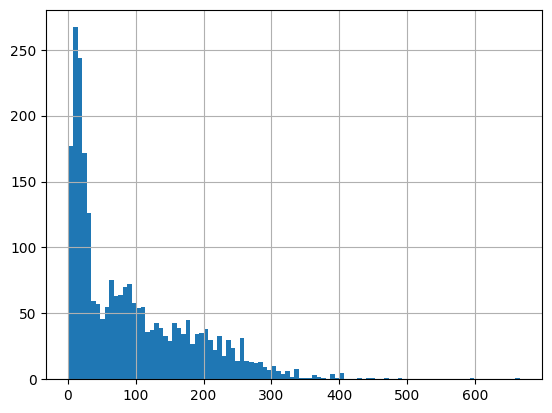

In [8]:
bulk_adata.obs['cell_count'].hist(bins=100)

## zero count issue 

In [9]:
mask_nonzero = bulk_adata.X!=0

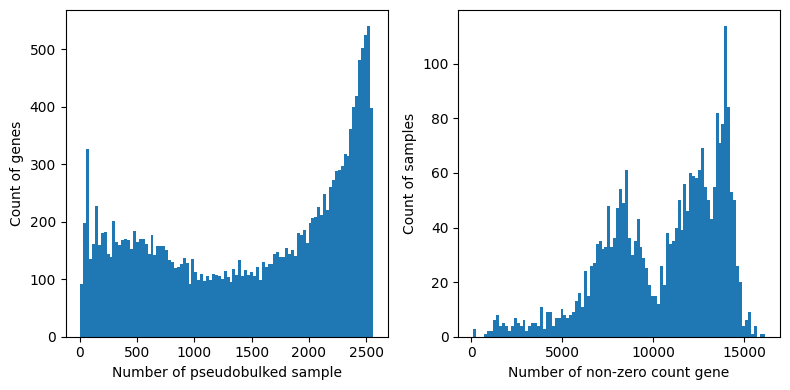

In [10]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
ax = axes[0]
ax.hist(mask_nonzero.sum(axis=0), bins=100)
ax.set_xlabel('Number of pseudobulked sample')
ax.set_ylabel('Count of genes')
# ax.set_title('Distribution of non-zero count gene ')

ax = axes[1]
ax.hist(mask_nonzero.sum(axis=1), bins=100)
ax.set_xlabel('Number of non-zero count gene')
ax.set_ylabel('Count of samples')
# ax.set_title('Number of genes for samples')
plt.tight_layout()

In [11]:
print('number of genes that are present at least in 1/3 of sample ')
mask_genes = mask_nonzero.sum(axis=0) > bulk_adata.shape[0]/3
mask_genes.sum()

number of genes that are present at least in 1/3 of sample 


12740

In [12]:
print('number of samples that has at least 1000 genes ')
mask_sample = mask_nonzero.sum(axis=1) > 1000
mask_sample.sum()

number of samples that has at least 1000 genes 


2553

In [13]:
# filter
bulk_adata_f = bulk_adata[mask_sample,mask_genes]
bulk_adata_f.shape

(2553, 12740)

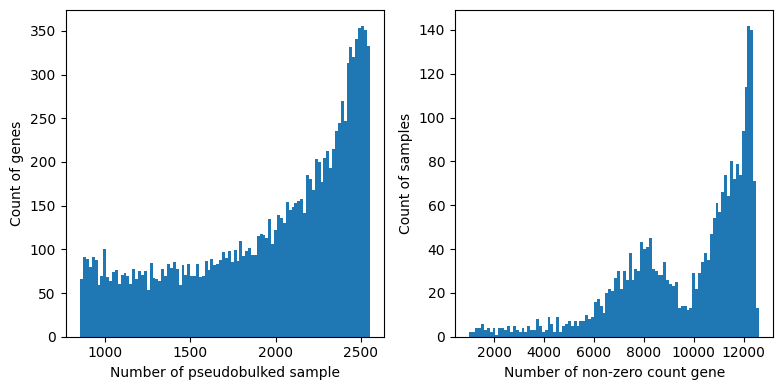

In [14]:
mask_nonzero_f = bulk_adata_f.X!=0
fig, axes = plt.subplots(1,2, figsize=(8,4))
ax = axes[0]
ax.hist(mask_nonzero_f.sum(axis=0), bins=100)
ax.set_xlabel('Number of pseudobulked sample')
ax.set_ylabel('Count of genes')
# ax.set_title('Distribution of non-zero count gene ')

ax = axes[1]
ax.hist(mask_nonzero_f.sum(axis=1), bins=100)
ax.set_xlabel('Number of non-zero count gene')
ax.set_ylabel('Count of samples')
# ax.set_title('Number of genes for samples')
plt.tight_layout()

## low cell count issue

1

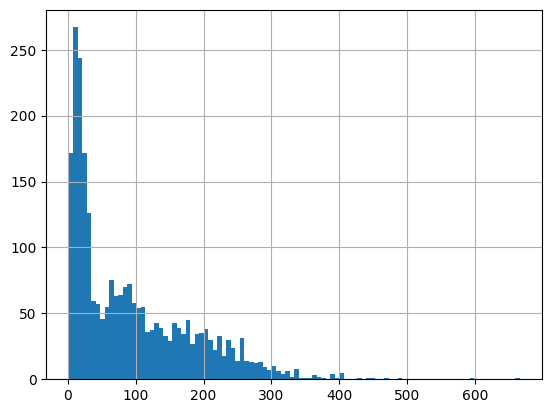

In [16]:
bulk_adata_f.obs['cell_count'].hist(bins=100)
bulk_adata_f.obs['cell_count'].min()

In [24]:
# at least 10 cell count
mask_low_cellcount = bulk_adata_f.obs['cell_count']<10
print(mask_low_cellcount.sum()/bulk_adata_f.shape[0])
print(bulk_adata_f.shape)
bulk_adata_f = bulk_adata_f[~mask_low_cellcount,:]
bulk_adata_f.shape

0.09009009009009009
(2553, 12740)


(2323, 12740)

## EDA

In [32]:
adata_pb = bulk_adata_f.copy()

In [33]:
adata_pb.layers['counts'] = adata_pb.X

In [53]:
adata_pb.X = adata_pb.layers['counts']
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)
sc.pp.neighbors(bulk_adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(bulk_adata)

## UMAP and PCA

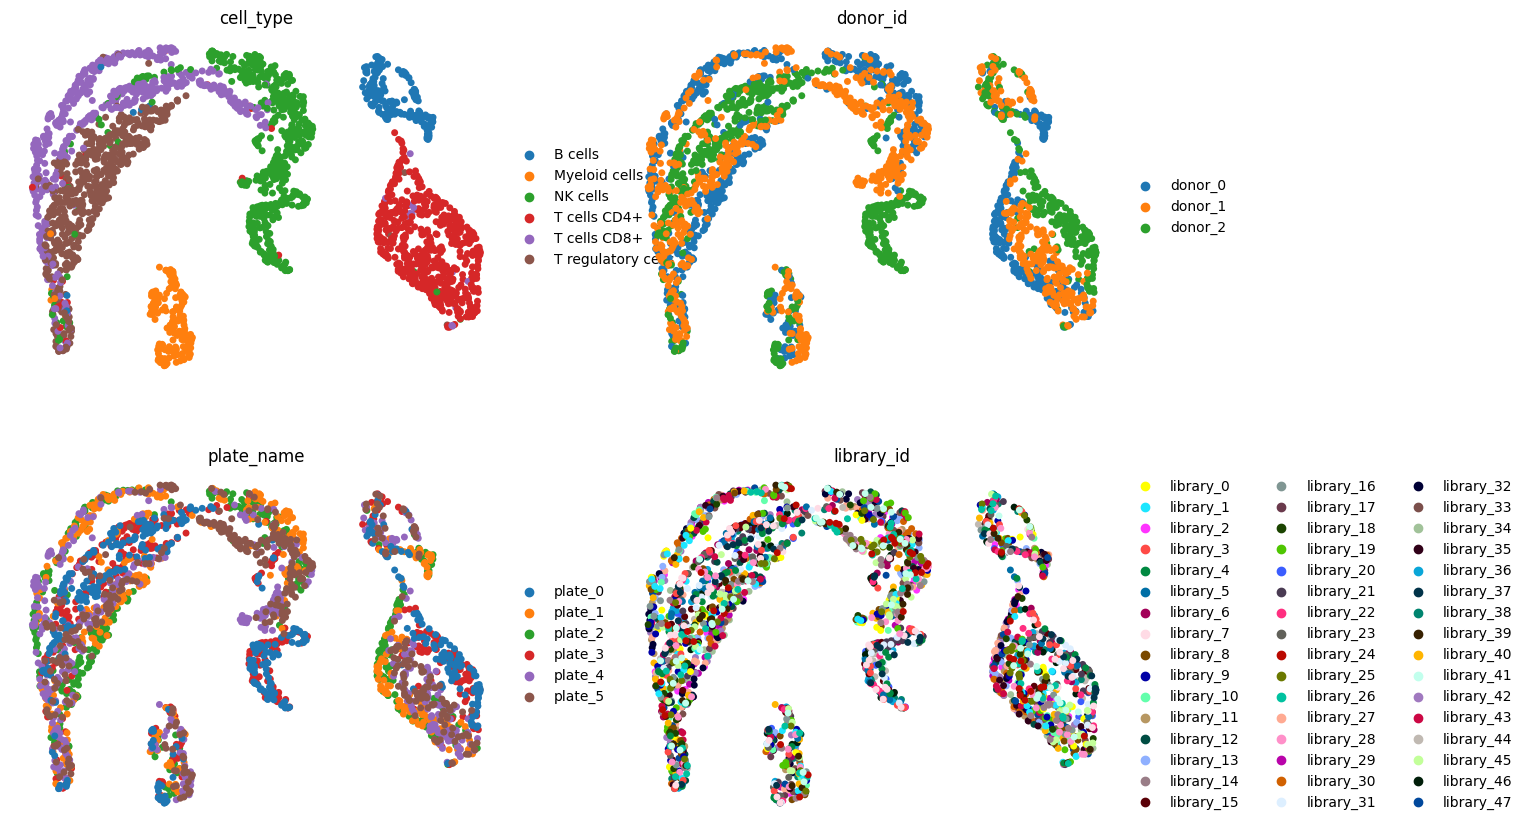

In [58]:
sc.pl.umap(bulk_adata, color=['cell_type', 'donor_id', 'plate_name', 'library_id'], frameon=False, ncols=2, size=100)

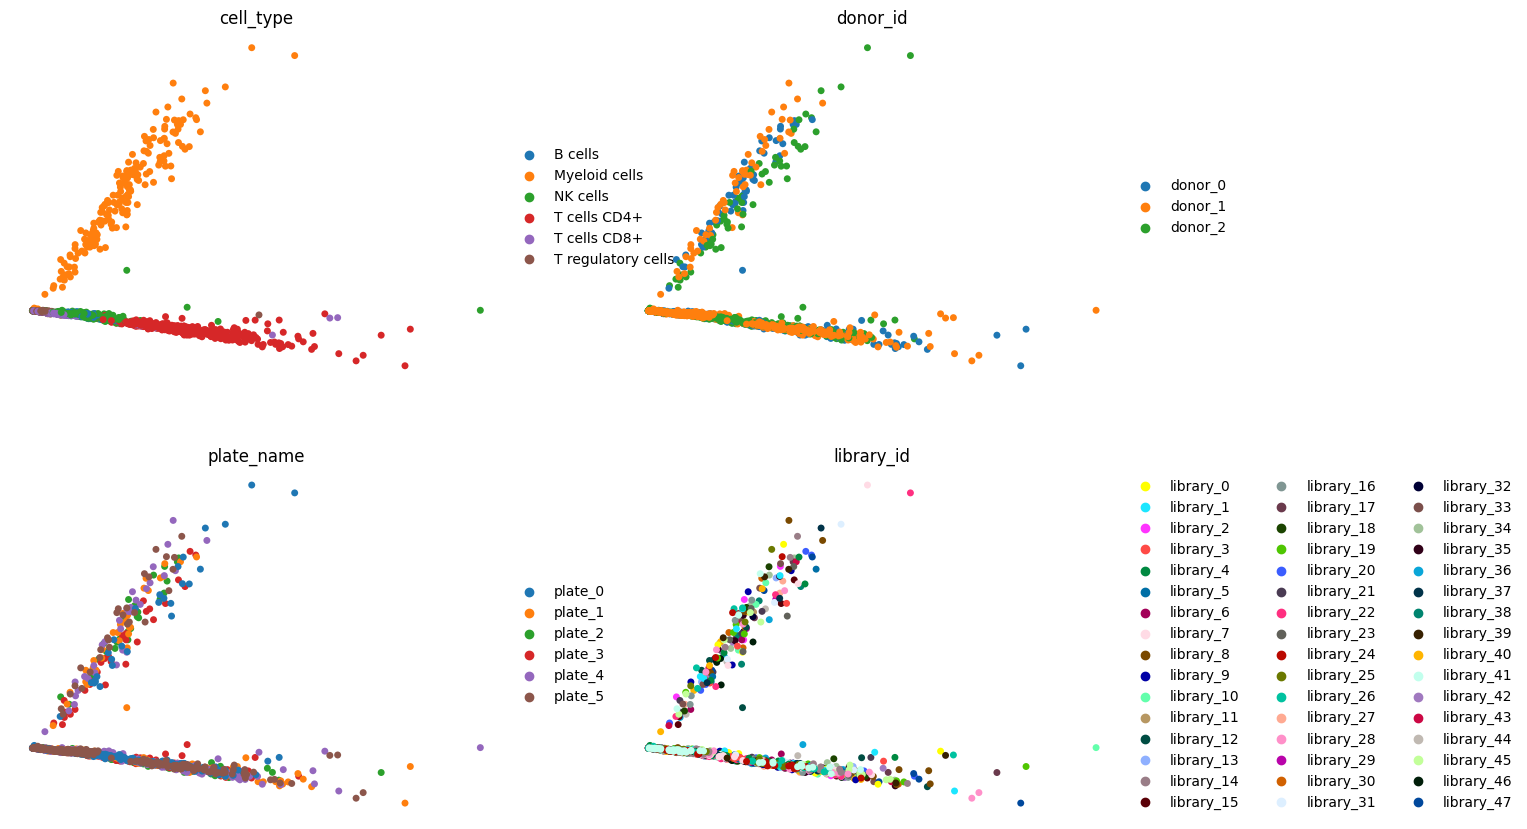

In [59]:
sc.pl.pca(bulk_adata, color=['cell_type', 'donor_id', 'plate_name', 'library_id'], frameon=False, ncols=2, size=100)

## make df and save

In [62]:
adata_pb.shape

(2323, 12740)

In [63]:
to_save = adata_pb
bulk_adata_df = pd.DataFrame(to_save.X, columns=to_save.var.index, index=to_save.obs.index)
bulk_adata_df = pd.concat([to_save.obs,  bulk_adata_df], axis=1)
bulk_adata_df.to_csv('../../output/de_analysis/bulk_adata_df.csv')

# DE analysis 
We use https://www.sc-best-practices.org/conditions/differential_gene_expression.html.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
# import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [70]:
adata_pb.X = adata_pb.layers['counts']


In [ ]:
import limma_utils
de_pert_cols = [
    'sm_name',
    'sm_lincs_id',
    'SMILES',
    'dose_uM',
    'timepoint_hr',
    'cell_type',
]

control_compound = 'Dimethyl Sulfoxide'

def _run_limma_for_cell_type(bulk_adata):
    bulk_adata = bulk_adata.copy()
    
    compound_name_col = 'sm_name'
    
    # limma doesn't like dashes etc. in the compound names
    rpert_mapping = bulk_adata.obs[compound_name_col].drop_duplicates() \
        .reset_index(drop=True).reset_index() \
        .set_index(compound_name_col)['index'].to_dict()
    
    bulk_adata.obs['Rpert'] = bulk_adata.obs.apply(
        lambda row: rpert_mapping[row[compound_name_col]], 
        axis='columns',
    ).astype('str')

    compound_name_to_Rpert = bulk_adata.obs.set_index(compound_name_col)['Rpert'].to_dict()
    ref_pert = compound_name_to_Rpert[control_compound]
            
    random_string = binascii.b2a_hex(os.urandom(15)).decode()
    
    
    limma_utils.limma_fit(
        bulk_adata, 
        design='~0+Rpert+donor_id+plate_name+row',
        output_path=f'output/{random_string}_limma.rds',
        plot_output_path=f'output/{random_string}_voom',
        exec_path='limma_fit.r',
    )

    pert_de_dfs = []
    


    for pert in bulk_adata.obs['Rpert'].unique():
        if pert == ref_pert:
            continue

        pert_de_df = limma_utils.limma_contrast(
            fit_path=f'output/{random_string}_limma.rds',
            contrast='Rpert'+pert+'-Rpert'+ref_pert,
            exec_path='limma_contrast.r',
        )

        pert_de_df['Rpert'] = pert

        pert_obs = bulk_adata.obs[bulk_adata.obs['Rpert'].eq(pert)]
        for col in de_pert_cols:
            pert_de_df[col] = pert_obs[col].unique()[0]
        pert_de_dfs.append(pert_de_df)

    de_df = pd.concat(pert_de_dfs, axis=0)

    try:
        os.remove(f'output/{random_string}_limma.rds')
        os.remove(f'output/{random_string}_voom')
    except FileNotFoundError:
        pass
    
    return de_df

run_limma_for_cell_type = delayed(_run_limma_for_cell_type)
cluster = LocalCluster(
    n_workers=6,
    processes=True,
    threads_per_worker=1,
    memory_limit='20GB',
)

c = Client(cluster)

In [115]:
adata_mono = adata_pb[adata_pb.obs["cell_type"] == "B cells"].copy()
adata_mono.X = adata_mono.X.astype(np.int64)
# these couses issues with rpy2 conversion 
adata_mono.obsm = {}
adata_mono.varm = {}
adata_mono.layers = {}
adata_mono.uns = {}

adata_mono


AnnData object with n_obs × n_vars = 180 × 12740
    obs: 'col', 'dose_uM', 'donor_id', 'cell_id', 'sm_lincs_id', 'plate_name', 'library_id', 'cell_type', 'control', 'sm_name', 'row', 'well', 'SMILES', 'timepoint_hr', 'cell_count'

In [91]:
%%R 
library(edgeR)
library(MAST)

In [118]:
%%time
%%R -i adata_mono
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$sm_name, ".", colData(adata_)$cell_type)
    replicate <- colData(adata_)$donor_id
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + replicate)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}
outs <-fit_model(adata_mono)

[1] "Dimensions before subsetting:"
[1] 12740   180
[1] ""
[1] "Dimensions after subsetting:"
[1] 7519  180
[1] ""
CPU times: user 25.3 s, sys: 75.1 ms, total: 25.4 s
Wall time: 25.4 s


In [120]:
%%R
fit <- outs$fit
y <- outs$y

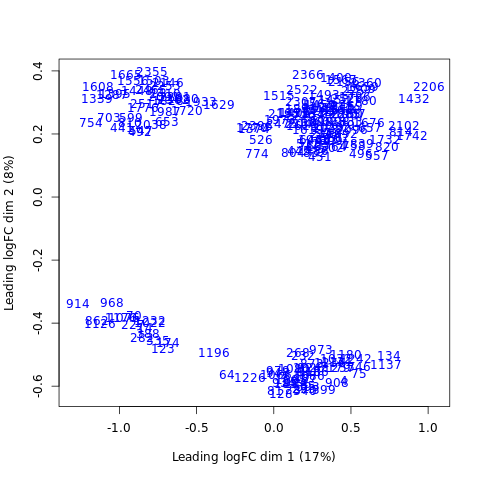

In [121]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "sm_name", "red", "blue"))

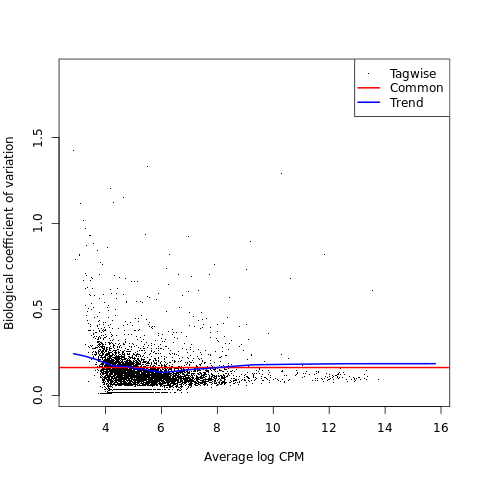

In [122]:
%%R
plotBCV(y)

In [123]:
%%R
colnames(y$design)

 [1] "groupBelinostat.B cells"              
 [2] "groupCHIR-99021.B cells"              
 [3] "groupCrizotinib.B cells"              
 [4] "groupDabrafenib.B cells"              
 [5] "groupDactolisib.B cells"              
 [6] "groupDimethyl Sulfoxide.B cells"      
 [7] "groupForetinib.B cells"               
 [8] "groupIdelalisib.B cells"              
 [9] "groupLDN 193189.B cells"              
[10] "groupLinagliptin.B cells"             
[11] "groupO-Demethylated Adapalene.B cells"
[12] "groupPalbociclib.B cells"             
[13] "groupPenfluridol.B cells"             
[14] "groupPorcn Inhibitor III.B cells"     
[15] "groupR428.B cells"                    
[16] "replicatedonor_1"                     
[17] "replicatedonor_2"                     


In [124]:
%%R -o tt
myContrast <- makeContrasts('groupIdelalisib.B cells-groupDabrafenib.B cells', levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

Error in makeContrasts("groupIdelalisib.B cells-groupDabrafenib.B cells",  : 
  The levels must by syntactically valid names in R, see help(make.names).  Non-valid names: groupBelinostat.B cells,groupCHIR-99021.B cells,groupCrizotinib.B cells,groupDabrafenib.B cells,groupDactolisib.B cells,groupDimethyl Sulfoxide.B cells,groupForetinib.B cells,groupIdelalisib.B cells,groupLDN 193189.B cells,groupLinagliptin.B cells,groupO-Demethylated Adapalene.B cells,groupPalbociclib.B cells,groupPenfluridol.B cells,groupPorcn Inhibitor III.B cells,groupR428.B cells


RInterpreterError: Failed to parse and evaluate line "myContrast <- makeContrasts('groupIdelalisib.B cells-groupDabrafenib.B cells', levels = y$design)\nqlf <- glmQLFTest(fit, contrast=myContrast)\n# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR\ntt <- topTags(qlf, n = Inf)\ntt <- tt$table\n".
R error message: 'Error in makeContrasts("groupIdelalisib.B cells-groupDabrafenib.B cells",  : \n  The levels must by syntactically valid names in R, see help(make.names).  Non-valid names: groupBelinostat.B cells,groupCHIR-99021.B cells,groupCrizotinib.B cells,groupDabrafenib.B cells,groupDactolisib.B cells,groupDimethyl Sulfoxide.B cells,groupForetinib.B cells,groupIdelalisib.B cells,groupLDN 193189.B cells,groupLinagliptin.B cells,groupO-Demethylated Adapalene.B cells,groupPalbociclib.B cells,groupPenfluridol.B cells,groupPorcn Inhibitor III.B cells,groupR428.B cells'

In [ ]:
%%R 


# DE analysis original

In [ ]:
import limma_utils
de_pert_cols = [
    'sm_name',
    'sm_lincs_id',
    'SMILES',
    'dose_uM',
    'timepoint_hr',
    'cell_type',
]

control_compound = 'Dimethyl Sulfoxide'

def _run_limma_for_cell_type(bulk_adata):
    bulk_adata = bulk_adata.copy()
    
    compound_name_col = de_pert_cols[0]
    
    # limma doesn't like dashes etc. in the compound names
    rpert_mapping = bulk_adata.obs[compound_name_col].drop_duplicates() \
        .reset_index(drop=True).reset_index() \
        .set_index(compound_name_col)['index'].to_dict()
    
    bulk_adata.obs['Rpert'] = bulk_adata.obs.apply(
        lambda row: rpert_mapping[row[compound_name_col]], 
        axis='columns',
    ).astype('str')

    compound_name_to_Rpert = bulk_adata.obs.set_index(compound_name_col)['Rpert'].to_dict()
    ref_pert = compound_name_to_Rpert[control_compound]
            
    random_string = binascii.b2a_hex(os.urandom(15)).decode()
    
    
    limma_utils.limma_fit(
        bulk_adata, 
        design='~0+Rpert+donor_id+plate_name+row',
        output_path=f'output/{random_string}_limma.rds',
        plot_output_path=f'output/{random_string}_voom',
        exec_path='limma_fit.r',
    )

    pert_de_dfs = []
    


    for pert in bulk_adata.obs['Rpert'].unique():
        if pert == ref_pert:
            continue

        pert_de_df = limma_utils.limma_contrast(
            fit_path=f'output/{random_string}_limma.rds',
            contrast='Rpert'+pert+'-Rpert'+ref_pert,
            exec_path='limma_contrast.r',
        )

        pert_de_df['Rpert'] = pert

        pert_obs = bulk_adata.obs[bulk_adata.obs['Rpert'].eq(pert)]
        for col in de_pert_cols:
            pert_de_df[col] = pert_obs[col].unique()[0]
        pert_de_dfs.append(pert_de_df)

    de_df = pd.concat(pert_de_dfs, axis=0)

    try:
        os.remove(f'output/{random_string}_limma.rds')
        os.remove(f'output/{random_string}_voom')
    except FileNotFoundError:
        pass
    
    return de_df

run_limma_for_cell_type = delayed(_run_limma_for_cell_type)
cluster = LocalCluster(
    n_workers=6,
    processes=True,
    threads_per_worker=1,
    memory_limit='20GB',
)

c = Client(cluster)

In [ ]:

cell_types = bulk_adata.obs['cell_type'].unique()
de_dfs = []

for cell_type in cell_types:
    cell_type_selection = bulk_adata.obs['cell_type'].eq(cell_type)
    cell_type_bulk_adata = bulk_adata[cell_type_selection].copy()
    
    de_df = run_limma_for_cell_type(cell_type_bulk_adata)
    
    de_dfs.append(de_df)

de_dfs = c.compute(de_dfs, sync=True)
de_df = pd.concat(de_dfs)

We compute DE for each cell type independently. Using Dask, we execute the DE expression function for each cell type in parallel.

## Converting DataFrame to Anndata

In [ ]:
# def convert_de_df_to_anndata(de_df_copy, pert_cols, de_sig_cutoff):
pert_cols = de_pert_cols
de_sig_cutoff = 0.05
de_df_copy = de_df.copy()
zero_pval_selection = de_df_copy['P.Value'].eq(0)
print('number of cases with zero p value:', zero_pval_selection.sum())
de_df_copy.loc[zero_pval_selection, 'P.Value'] = np.finfo(np.float64).eps

de_df_copy['sign_log10_pval'] = np.sign(de_df_copy['logFC']) * -np.log10(de_df_copy['P.Value'])
de_df_copy['is_de'] = de_df_copy['P.Value'].lt(de_sig_cutoff)
de_df_copy['is_de_adj'] = de_df_copy['adj.P.Val'].lt(de_sig_cutoff)

de_feature_dfs = {}
for feature in ['is_de', 'is_de_adj', 'sign_log10_pval', 'logFC', 'P.Value', 'adj.P.Val']:
    df = de_df_copy.reset_index().pivot_table(
        index=['gene'], 
        columns=pert_cols,
        values=[feature],
        dropna=True,
    )
    de_feature_dfs[feature] = df


In [ ]:
df_copy = de_feature_dfs['sign_log10_pval'].T.copy()
df_copy.index = df_copy.index.to_frame(index=False).drop(columns=[0])

In [ ]:
gene_names = de_feature_dfs['sign_log10_pval'].index
X = de_feature_dfs['sign_log10_pval'].T[gene_names].values
obs = de_feature_dfs['sign_log10_pval'].T.index.to_frame(index=False).drop(columns=[0])
var = pd.DataFrame(index=gene_names)
de_adata = ad.AnnData(X, dtype=np.float64, obs=obs,var=var)
# de_adata.obs = de_adata.obs.reset_index()
# de_adata.obs = de_adata.obs.drop(columns=['level_0'])
# de_adata.obs.index = de_adata.obs.index.astype('string')

de_adata.layers['is_de'] = de_feature_dfs['is_de'].to_numpy().T
de_adata.layers['is_de_adj'] = de_feature_dfs['is_de_adj'].to_numpy().T
de_adata.layers['logFC'] = de_feature_dfs['logFC'].to_numpy().T
de_adata.layers['P.Value'] = de_feature_dfs['P.Value'].to_numpy().T
de_adata.layers['adj.P.Val'] = de_feature_dfs['adj.P.Val'].to_numpy().T
    
    # return de_adata
# de_adata = convert_de_df_to_anndata(de_df, de_pert_cols, 0.05)

## Validation

Let's make sure that the DE object we've computed has the exact same values as the DE object obtained from `de_train.parquet`

In [ ]:
kaggle_train_de_df = pd.read_parquet(os.path.join(data_dir, 'de_train.parquet'))
kaggle_train_de_df = kaggle_train_de_df.set_index(list(kaggle_train_de_df.columns[:5]))
obs = kaggle_train_de_df.index.to_frame(index=False)
var = pd.DataFrame(index=kaggle_train_de_df.columns)
kaggle_train_de_adata = ad.AnnData(kaggle_train_de_df.values, obs=obs, var=var, dtype=np.float64)
# kaggle_train_de_adata.obs = kaggle_train_de_adata.obs.reset_index()
# kaggle_train_de_adata.obs.index = kaggle_train_de_adata.obs.index.astype('str')

In [ ]:
sorting_index = kaggle_train_de_adata.obs.sort_values(['sm_name', 'cell_type']).index
kaggle_train_de_adata = kaggle_train_de_adata[sorting_index].copy()

In [ ]:
kaggle_train_de_adata

In [ ]:
de_adata.obs.index = de_adata.obs.index.astype('str')

sorting_index = de_adata.obs.sort_values(['sm_name', 'cell_type']).index
de_adata = de_adata[sorting_index].copy()

In [ ]:
np.allclose(kaggle_train_de_adata.X, de_adata.X)

# Evaluate 

In [ ]:
de_adata

In [ ]:
bulk_adata.X==0